# Sentiment Prediction from Movie Review (IMDB)

**Predicting positive or negative sentiments from movie reviews**

**Natural Language Processing. Supervised Learning. Classification**

Dataset: [IMDB Movie reviews sentiment classification](https://keras.io/datasets/)

In [1]:
%matplotlib inline

import os, sys
import ds_boost
import tensorflow


# import tensorflow as tf
# from tensorflow import keras
log = ds_boost.logger.init(level="DEBUG", save_log=False)


ds_boost.set_parent_execution_path()
ds_boost.info_system()
ds_boost.reproducible(seed=9)  # setup reproducible results from run to run using Keras

23:02:33 - DEBUG 	 Path changed to /home/angel/DRIVE/0_repos/data-science-keras
23:02:33 - DEBUG 	 HARDWARE:
23:02:35 - DEBUG 	 CPU:	Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
23:02:35 - DEBUG 	 RAM:	15 GB
23:02:35 - DEBUG 	 -- No GPU  --
23:02:35 - DEBUG 	 OS:	Linux-5.15.0-57-generic-x86_64-with-glibc2.35
23:02:35 - DEBUG 	 ENV:	/home/angel/miniconda3/envs/ds-keras
23:02:35 - DEBUG 	 PYTHON:	3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
23:02:35 - DEBUG 	 tensorflow                   2.11.0
23:02:35 - DEBUG 	 pandas                        1.5.2
23:02:35 - DEBUG 	 numpy                        1.24.1
23:02:35 - DEBUG 	 EXECUTION PATH: /home/angel/DRIVE/0_repos/data-science-keras
23:02:35 - DEBUG 	 EXECUTION DATE: Mon Jan 16 23:02:35 2023


## Load the data

In [2]:
from tensorflow.keras.datasets import imdb

max_words = 20000  # most common words
max_length = 500  # words per review limit

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words, skip_top=0, maxlen=max_length)
# dictionaries ids <-> words
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}

print("Training reviews: {}".format(len(x_train)))
print("Testing reviews: {}".format(len(x_test)))

print("\nReview:")
print([id2word.get(i, " ") for i in x_train[2]])
print("\nLabel: {}".format(y_train[2]))
print("0: negative, 1:positive")

Training reviews: 22882
Testing reviews: 23065

Review:
['the', 'as', 'there', 'in', 'at', 'by', 'br', 'of', 'sure', 'many', 'br', 'of', 'proving', 'no', 'only', 'women', 'was', 'than', "doesn't", 'as', 'you', 'never', 'of', 'hat', 'night', 'that', 'with', 'ignored', 'they', 'bad', 'out', 'superman', 'plays', 'of', 'how', 'star', 'so', 'stories', 'film', 'comes', 'defense', 'date', 'of', 'wide', 'they', "don't", 'do', 'that', 'had', 'with', 'of', 'hollywood', 'br', 'of', 'my', 'seeing', 'fan', 'this', 'of', 'pop', 'out', 'body', 'shots', 'in', 'having', 'because', 'cause', "it's", 'stick', 'passing', 'first', 'were', 'enjoys', 'for', 'from', 'look', 'seven', 'sense', 'from', 'me', 'and', 'die', 'in', 'character', 'as', 'cuban', 'issues', 'but', 'is', 'you', 'that', "isn't", 'one', 'song', 'just', 'is', 'him', 'less', 'are', 'strongly', 'not', 'are', 'you', 'that', 'different', 'just', 'even', 'by', 'this', 'of', 'you', 'there', 'is', 'eight', 'when', 'it', 'part', 'are', "film's", 'lov

In [3]:
print("Positive review rate: {:.3f}".format(y_train.mean()))

Positive review rate: 0.496


**Balanced target**

## Process the data

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# padding
x_train = pad_sequences(x_train, max_length)
x_test = pad_sequences(x_test, max_length)

# one-hot encoding the target
num_classes = 2
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

print("Training set:  x-shape={}  y-shape={}".format(x_train.shape, y_train.shape))
print("Testing  set:  x-shape={}  y-shape={}".format(x_test.shape, y_test.shape))

Training set:  x-shape=(22882, 500)  y-shape=(22882, 2)
Testing  set:  x-shape=(23065, 500)  y-shape=(23065, 2)


## Neural Network model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 10)           200000    
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 8)                 40008     
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 240,026
Trainable params: 240,026
Non-trainable params: 0
_________________________________________________________________
Training ....

CPU times: user 35.8 s, sys: 1.41 s

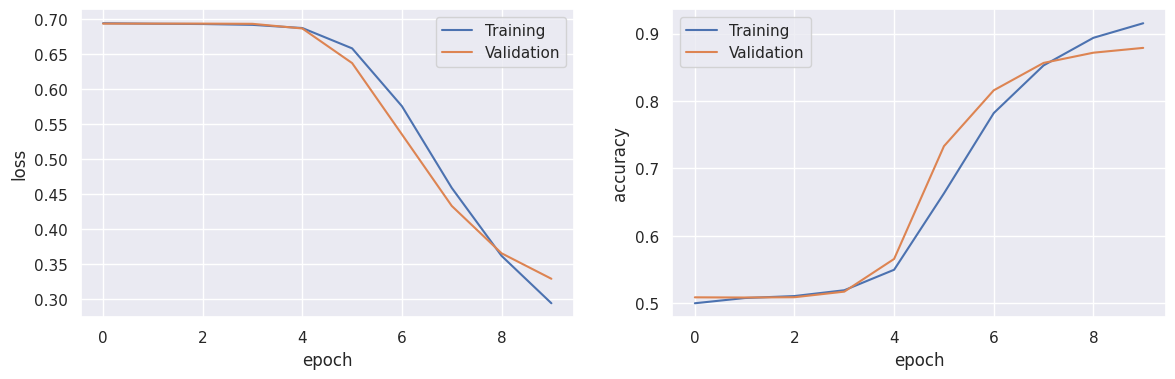

23:02:52 - DEBUG 	 Training loss:  	0.2939
23:02:52 - DEBUG 	 Validation loss: 	 0.3288
23:02:52 - DEBUG 	 Training accuracy: 	0.915
23:02:52 - DEBUG 	 Validation accuracy:	0.879

Model saved at models/sentiment_IMDB_model.h5


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Embedding

model = Sequential()
model.add(Embedding(max_words, 10, input_length=max_length))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Training ....\n')
callbacks = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=1)]
%time history = model.fit(x_train, y_train, batch_size=1024, epochs=10, verbose=0, \
                          validation_split = 0.3, callbacks=callbacks)
ds_boost.show_training(history)

model_path = os.path.join("models", "sentiment_IMDB_model.h5")
model.save(model_path)
print("\nModel saved at",model_path)

## Evaluate and Predict

In [6]:
model = tensorflow.keras.models.load_model(model_path)
print("Model loaded:", model_path)

score = model.evaluate(x_test, y_test, verbose=0)
print("\nTest Accuracy: {:.2f}\n".format(score[1]))

Model loaded: models/sentiment_IMDB_model.h5

Test Accuracy: 0.87



In [7]:
import re
import nltk


def review_to_ids(review):
    """Convert a raw review string into a sequence of ids"""

    review = re.sub(r"[^a-zA-Z0-9]", " ", review)  # remove non-letters
    review = review.lower()  # convert to lowercase
    words = review.split()  # tokenize
    ids = [word2id.get(i, 0) for i in words]
    ids = pad_sequences([ids], max_length)

    return ids


def predict(review):
    """Show the probability of positive sentiment given a string review"""
    my_ids = review_to_ids(review)
    print("Positive Probability: {:.2f}".format(model.predict(my_ids, verbose=0)[0][1]))

In [8]:
my_review = """The writer and director did well on his first movie, but this one is an absolute 
nonsense. I like complicated, non-linear, and abstract movies, although nothing can be learn 
from this messy script. The only thing worth it is the photography """
predict(my_review)

Positive Probability: 0.62


In [9]:
# http://www.imdb.com/user/ur12188407/
my_review = """ In short, this is one of the best sci-fi movies I have seen in a LONG time. 
Sam Rockwell plays it perfect, making the viewer feel his isolation and loneliness. For a low 
budget film, the few effect shots work seamlessly. I'm trying to remain spoiler free, so I won't
bother to explain the plot. If you like older and more story/character driven sci-fi, such as 
2001: A Space Odyssey, than chances are you will love this movie. If you aren't a huge fan of 
sci-fi, take a chance with this one. You may find it a very rewarding experience. I loved this 
movie, and I can't stop thinking about it. In Moon, you may begin to think that everything is a 
big cliché, but than with all of the seemingly cliché plot points, Moon changes them into 
something entirely original and unexpected. It is an excellent piece of art and I have a strong 
feeling not enough people will see and appreciate it like I did."""
predict(my_review)

Positive Probability: 0.75
